In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

import pymc3 as pm
import pandas as pd
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)
%matplotlib inline

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 4.1 線形単回帰

### コード4.1 さまざまなガンマ分布を出力する

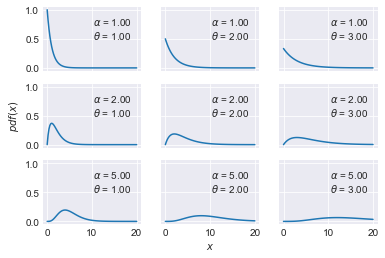

In [2]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)

for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i, j].plot(x, rv.pdf(x))
        ax[i, j].plot(0, 0, label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i, j].legend()
        
ax[2, 1].set_xlabel('$x$')
ax[1, 0].set_ylabel('$pdf(x)$')

### コード4.2 回帰直線を既知として人工データを生成する

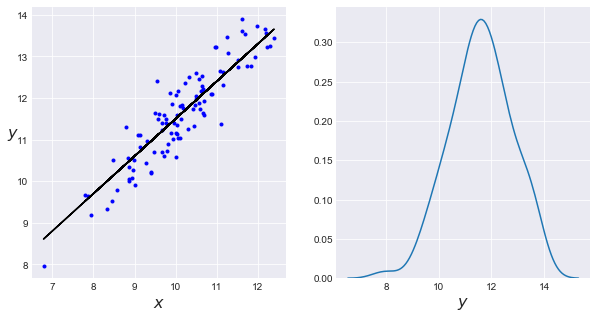

In [3]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1, 2, 2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)

### コード4.3 ベイジアン線形回帰モデルのパラメータのKDEとトレースを出力する（１）

In [4]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(11000, step, start, njobs=1)

logp = -71.578, ||grad|| = 0.14936: 100%|██████████| 36/36 [00:00<00:00, 1339.13it/s]  
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 11500/11500 [00:05<00:00, 2092.63it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ee5acc0>,
      dtype=object)

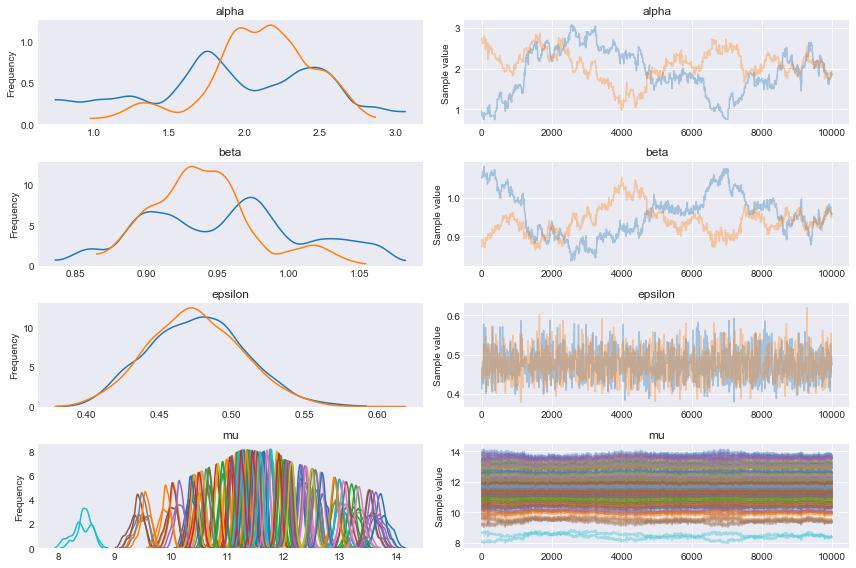

In [5]:
trace_n = trace[1000:]
pm.traceplot(trace_n)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123aae320>,
      dtype=object)

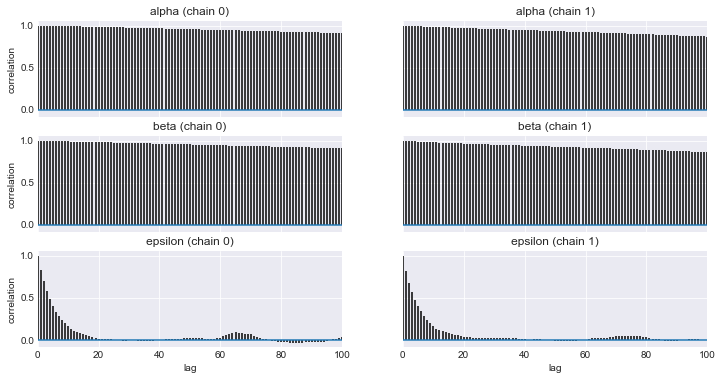

In [6]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace_n, varnames)

### コード4.6 パラメータαとβの事後分布のKDEを出力する

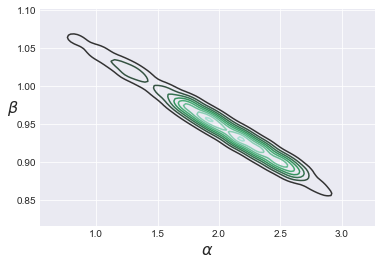

In [7]:
sns.kdeplot(trace_n['alpha'], trace_n['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

### コード4.7 平均αと平均βによる平均回帰直線を描く

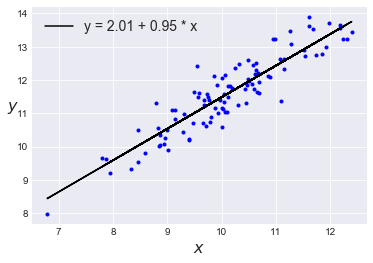

In [8]:
plt.plot(x, y, 'b.')
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$',fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

### コード4.8 平均αと平均βによる平均回帰直線の不確実性を示す

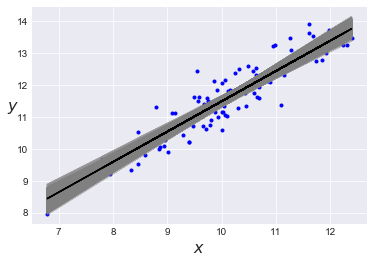

In [9]:
plt.plot(x, y, 'b.')
idx = range(0, len(trace_n['alpha']), 10)
plt.plot(x, trace_n['alpha'][idx] + trace_n['beta'][idx] * x[:, np.newaxis], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$',fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

### コード4.9 回帰直線の最高事後密度（HPD)を示す

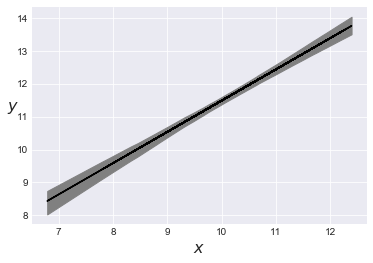

In [10]:
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_n['mu'], alpha=0.02)[idx]
plt.fill_between(x_ord, sig[:, 0], sig[:, 1], color='gray')
plt.xlabel('$x$',fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

### コード4.10,11 線形回帰モデルによる予測データの95%HPDと50%HPDを出力する

100%|██████████| 1000/1000 [00:01<00:00, 860.90it/s]


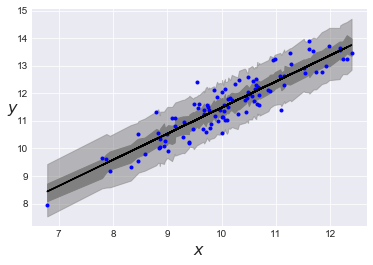

In [11]:
ppc = pm.sample_ppc(trace_n, samples=1000, model=model)
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1= pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:, 0], sig0[:, 1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:, 0], sig1[:,  1], color='gray', alpha=0.5)

plt.xlabel('$x$',fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

### コード4.12 線形回帰モデルにおける回帰係数、相関係数、決定係数を出力する

logp = -71.578, ||grad|| = 0.14936: 100%|██████████| 36/36 [00:00<00:00, 1529.17it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains:  59%|█████▊    | 2929/5000 [00:09<00:06, 334.57draws/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 5000/5000 [00:16<00:00, 302.08draws/s]
The acceptance probability does not match the target. It is 0.8858554871565164, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b07d320>,
      dtype=object)

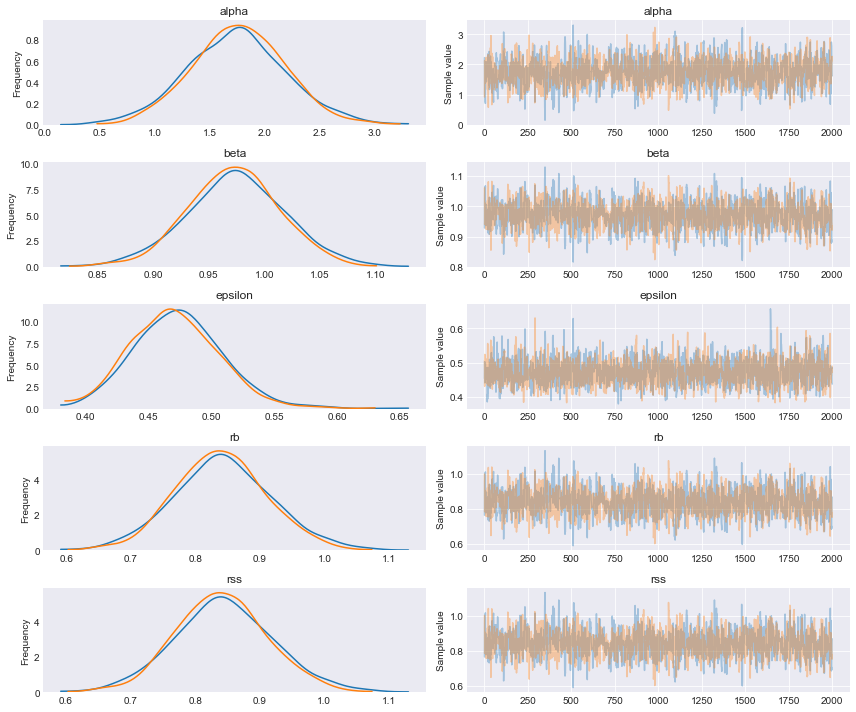

In [12]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real

with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) **2)
    
    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_n = pm.sample(2000, step=step, start=start)

pm.traceplot(trace_n)

In [13]:
varnames = ['alpha', 'beta', 'epsilon', 'rb', 'rss']
pm.summary(trace_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.75,0.44,1.30e-02,0.84,2.58,1089.85,1.0
beta,0.97,0.04,1.27e-03,0.89,1.06,1126.53,1.0
epsilon,0.47,0.04,7.78e-04,0.40,0.54,1668.75,1.0
rb,0.84,0.07,2.19e-03,0.70,1.00,1111.86,1.0
rss,0.84,0.07,2.19e-03,0.71,1.00,1105.16,1.0


### コード4.14 さまざまなピアソンの相関係数のもとで２変量正規分布を出力する

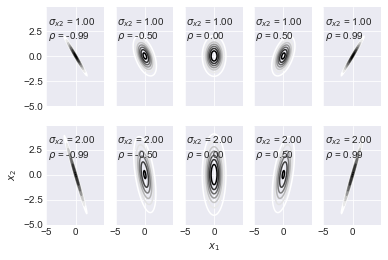

In [17]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

x, y = np.mgrid[-5:5:0.1, -5:5:0.1]
pos = np.empty(x.shape + (2, ))
pos[:, :, 0] = x
pos[:, :, 1] = y

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)

for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
                  [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(x, y, rv.pdf(pos))
        ax[i, j].plot(0, 0, label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax[i, j].legend()
ax[1, 2].set_xlabel('$x_1$')
ax[1, 0].set_ylabel('$x_2$')

### コード4.15 二つの平均値、二つの標準偏差、相関係数のKDEとトレースを出力する

logp = -244.04, ||grad|| = 129.68: 100%|██████████| 21/21 [00:00<00:00, 368.07it/s]  
Sequential sampling (2 chains in 1 job)
NUTS: [rho, sigma_2, sigma_1, mu]
 50%|█████     | 754/1500 [00:09<00:09, 75.73it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 1500/1500 [00:18<00:00, 81.81it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127e49d68>,
      dtype=object)

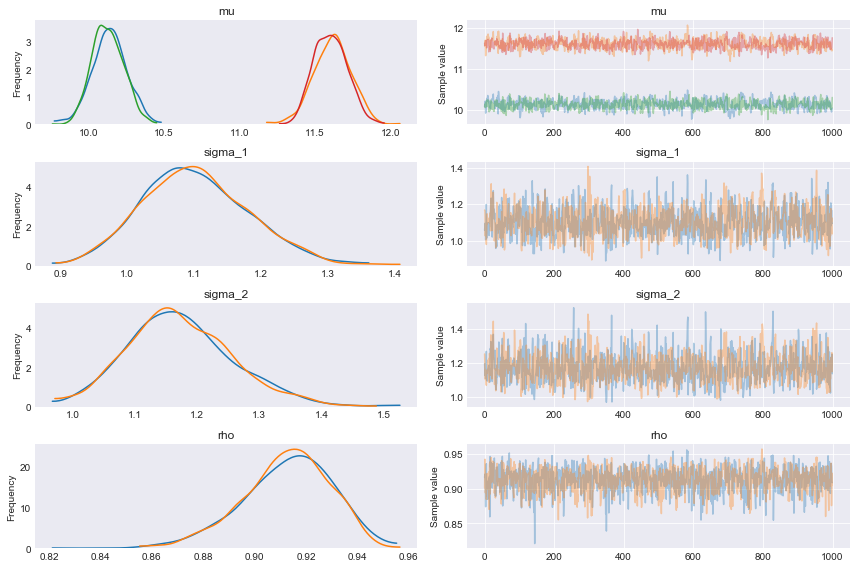

In [18]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real

data = np.stack((x, y)).T

with pm.Model() as pearson_model:
    
    mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)
    
    sigma_1 = pm.HalfNormal('sigma_1', 10)
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    rho = pm.Uniform('rho', -1, 1)
    
    cov = pm.math.stack(([sigma_1**2, sigma_1*sigma_2*rho], [sigma_1*sigma_2*rho, sigma_2**2]))
    
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_p = pm.sample(1000, step=step, start=start, njobs=1)
    
pm.traceplot(trace_p)

## 4.2 頑健線形回帰

### コード4.16 アンスコムのカルテット（３番目のデータセット）を出力する

In [19]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

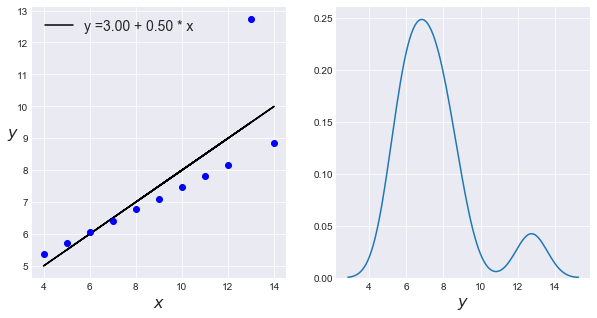

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c*x_3), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=0, fontsize=14)
plt.subplot(1, 2, 2)
sns.kdeplot(y_3)
plt.xlabel('$y$', fontsize=16)

### コード4.18 アンスコムのデータに対して頑健推定された直線と非頑健推定の直線を描く

In [21]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3, sd=epsilon, nu=nu, observed=y_3)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_t = pm.sample(2000, step=step, start=start, njobs=1)

logp = -182.3, ||grad|| = 60.63: 100%|██████████| 147/147 [00:00<00:00, 1117.54it/s] 
Sequential sampling (2 chains in 1 job)
NUTS: [nu_, epsilon, beta, alpha]
  9%|▉         | 223/2500 [00:09<01:41, 22.49it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 2500/2500 [05:03<00:00,  8.23it/s]
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated num

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,4.01e+00,1.54e-09,1.51e-10,4.01e+00,4.01e+00,7.90,1.13
beta,3.45e-01,2.89e-10,2.86e-11,3.45e-01,3.45e-01,7.12,1.05
epsilon,7.21e-06,2.08e-09,2.02e-10,7.21e-06,7.21e-06,9.67,1.04
nu_,3.05e-02,3.12e-02,4.88e-04,4.57e-06,9.36e-02,4193.49,1.00
nu,1.03e+00,3.12e-02,4.88e-04,1.00e+00,1.09e+00,4193.49,1.00


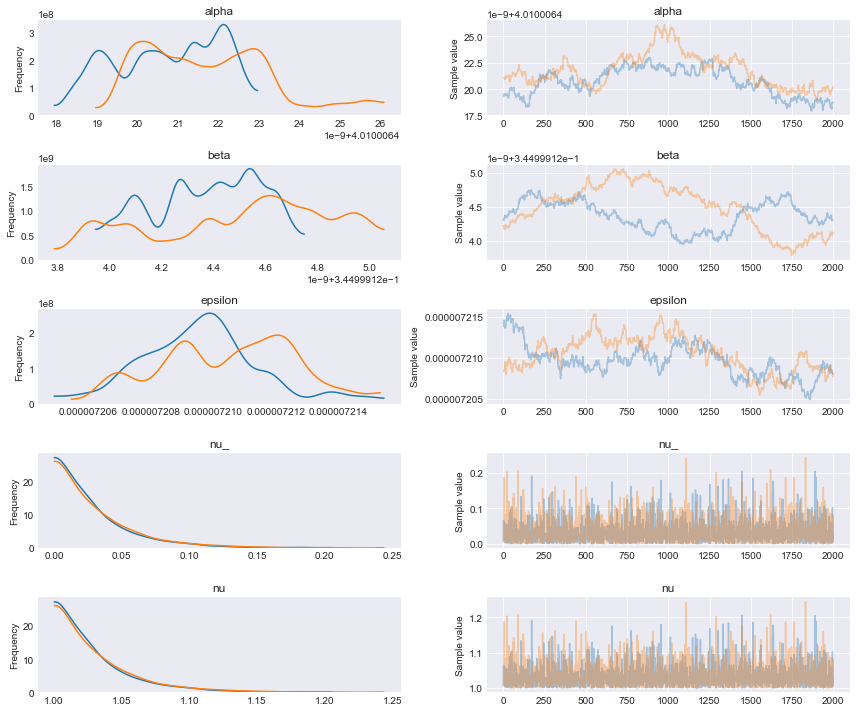

In [22]:
pm.traceplot(trace_t)
pm.summary(trace_t)

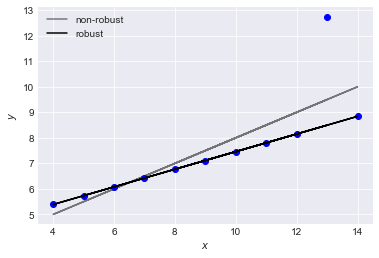

In [23]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c*x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, (alpha_m + beta_m*x_3), 'k', label='robust')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc=2)

### コード4.20 アンスコムのデータに対して事後予測チェックをする

100%|██████████| 200/200 [00:01<00:00, 113.45it/s]
/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


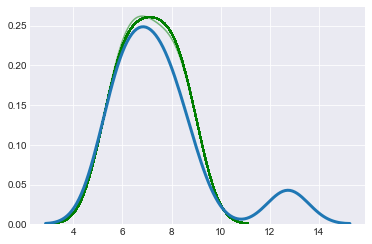

In [24]:
ppc = pm.sample_ppc(trace_t, samples=200, model=model_t, random_seed=2)
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='g')
sns.kdeplot(y_3, linewidth=3)

## 4.3 階層線形回帰

### コード4.21 ８種類のデータグループを描く

In [25]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

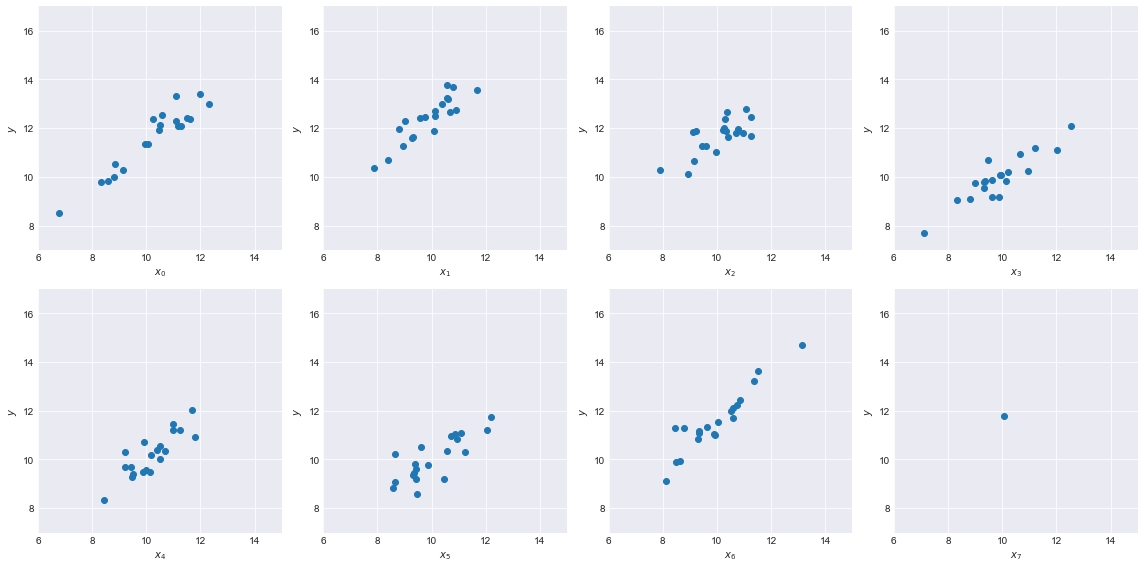

In [26]:
plt.figure(figsize=(16, 8))
j, k = 0, N
for i in range(M):
    plt.subplot(2, 4, i + 1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i))
    plt.ylabel('$y$')
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

### 非階層モデルにパラメータをフィットさせる

In [27]:
# データの中心化
x_centered = x_m - x_m.mean()

In [28]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_up = pm.sample(2000, step=step, start=start, njobs=1)

logp = -150.1, ||grad|| = 0.063834: 100%|██████████| 75/75 [00:00<00:00, 1101.40it/s]  
Sequential sampling (2 chains in 1 job)
NUTS: [nu, epsilon, beta, alpha_tmp]
100%|██████████| 2500/2500 [00:05<00:00, 427.31it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132968a20>,
      dtype=object)

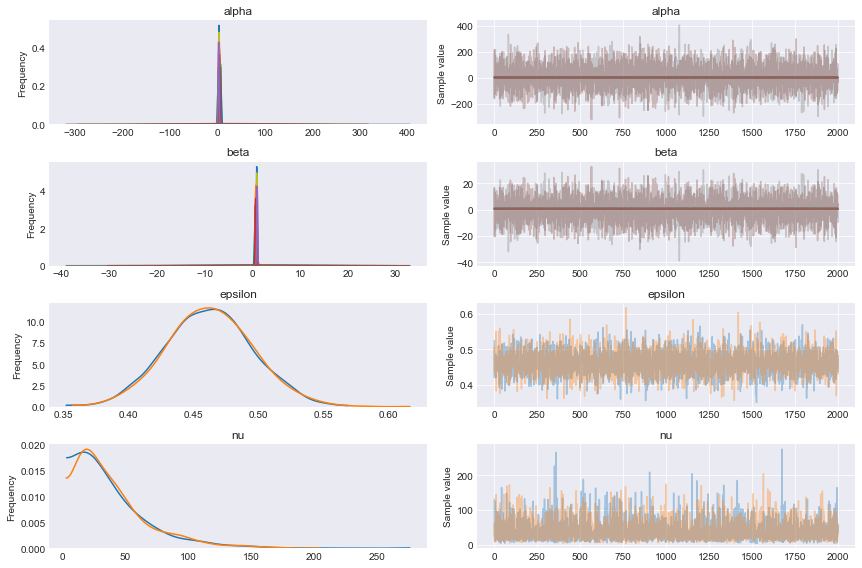

In [30]:
varnames = ['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)

In [31]:
pm.summary(trace_up, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,2.43,0.79,1.02e-02,0.87,3.93,7138.33,1.0
alpha__1,3.70,1.17,1.32e-02,1.38,6.04,8776.05,1.0
alpha__2,5.66,1.29,1.17e-02,3.09,8.27,8235.03,1.0
alpha__3,3.04,0.88,9.13e-03,1.32,4.76,8930.11,1.0
alpha__4,1.30,1.35,1.45e-02,-1.32,3.93,6999.74,1.0
alpha__5,3.22,1.03,1.07e-02,1.10,5.12,8874.33,1.0
alpha__6,1.74,0.92,1.07e-02,-0.07,3.53,8391.23,1.0
alpha__7,10.78,99.12,1.12e+00,-189.58,192.75,7490.68,1.0
beta__0,0.89,0.08,9.76e-04,0.74,1.04,7202.33,1.0
beta__1,0.88,0.12,1.32e-03,0.63,1.10,8956.31,1.0


### コード4.26 ８グループのデータセットに対する階層モデルのKDEとトレースを出力する

In [32]:
with pm.Model() as hierarchical_model:
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', 10)
    
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    
    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    trace_hm = pm.sample(1000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, epsilon, beta, alpha_tmp, beta_sd, beta_mu, alpha_tmp_sd, alpha_tmp_mu]
 53%|█████▎    | 801/1500 [00:09<00:08, 80.77it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 1500/1500 [00:08<00:00, 166.78it/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12dbcd710>,
      dtype=object)

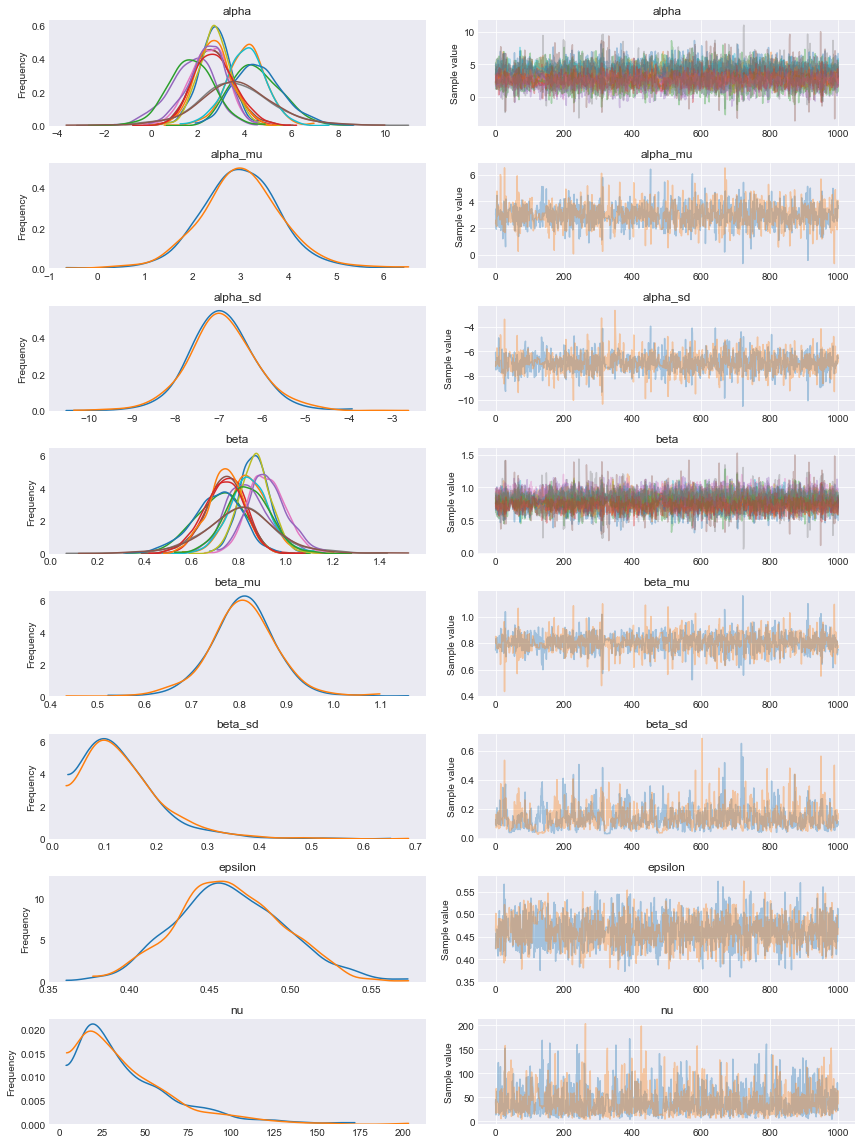

In [33]:
varnames = ['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(trace_hm, varnames)

### コード4.28 ８グループのデータセットに対する階層モデルにより回帰直線を描く

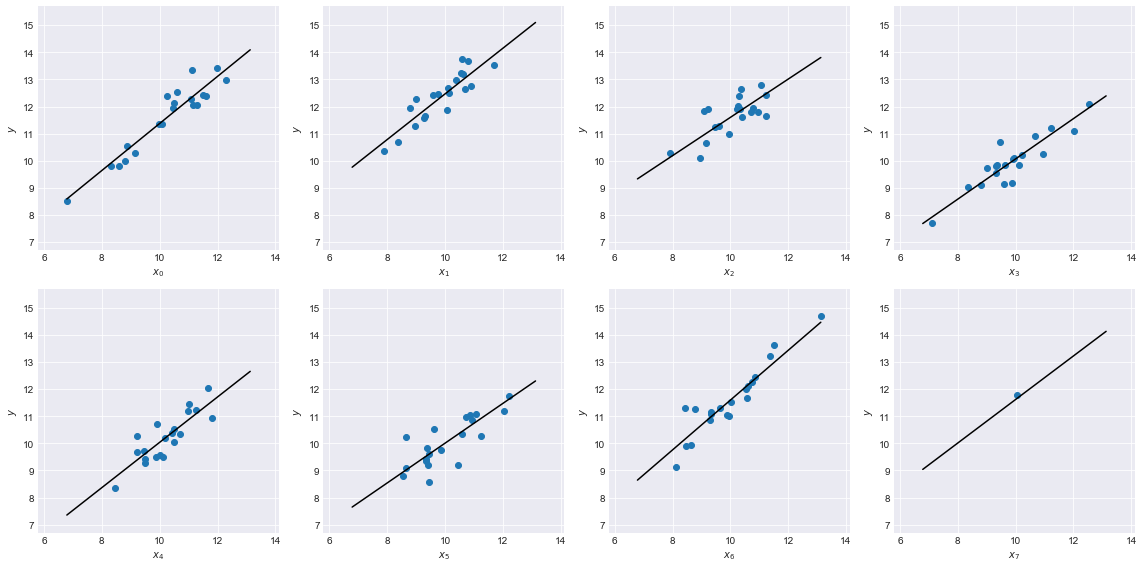

In [34]:
plt.figure(figsize=(16, 8))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2, 4, i + 1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i))
    plt.ylabel('$y$')
    alpha_m = trace_hm['alpha'][:, i].mean()
    beta_m = trace_hm['beta'][:, i].mean()
    plt.plot(x_range, alpha_m + beta_m * x_range, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()

## 4.4 多項式回帰

### コード4.29 アンスコムの２番目のグループのデータセットを表示する

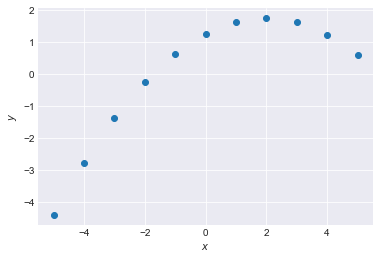

In [35]:
ans = sns.load_dataset('anscombe')
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$')
plt.ylabel('$y$')

### コード4.30 多項式回帰モデルのパラメータのKDEとトレースを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta2, beta1, alpha]
 90%|█████████ | 2262/2500 [00:09<00:01, 227.55it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 2500/2500 [00:10<00:00, 232.53it/s]
The acceptance probability does not match the target. It is 0.911388974404959, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9478674000153116, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133a95048>,
      dtype=object)

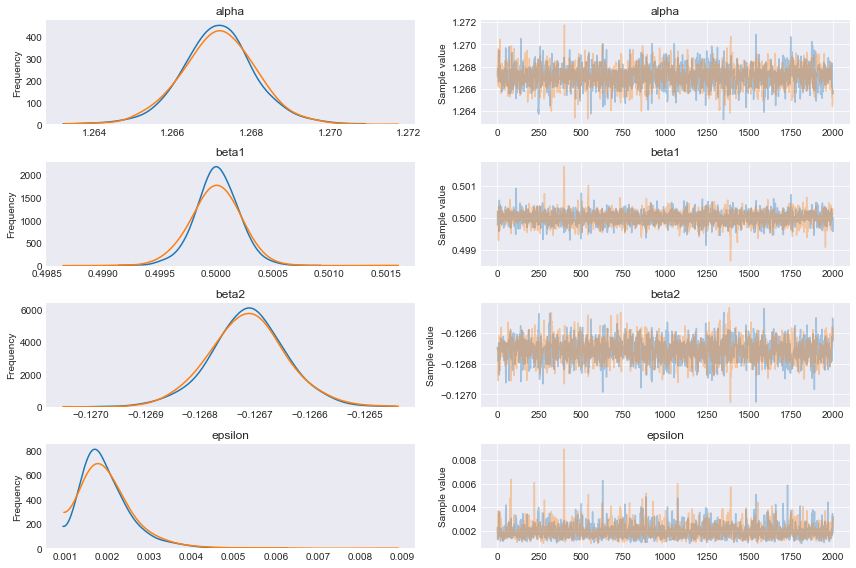

In [36]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)
    
    tracce_poly = pm.sample(2000, njobs=1)
    
pm.traceplot(tracce_poly)

### コード4.31 アンスコムのデータに多項式回帰をフィッティングする

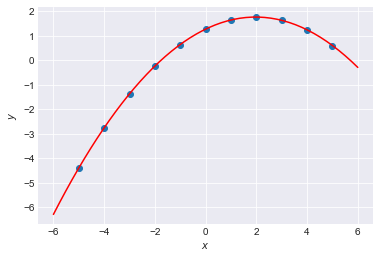

In [37]:
x_p = np.linspace(-6, 6)
y_p = tracce_poly['alpha'].mean() + tracce_poly['beta1'].mean() * x_p + tracce_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(x_p, y_p, c='r')

## 4.5 線形重回帰

### コード 4.32 変数間の散布図を描く

In [38]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

In [39]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx+1))
        plt.ylabel('$y$', rotation=0)
        
    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx))
    plt.ylabel('$x_{}$'.format(idx+1))

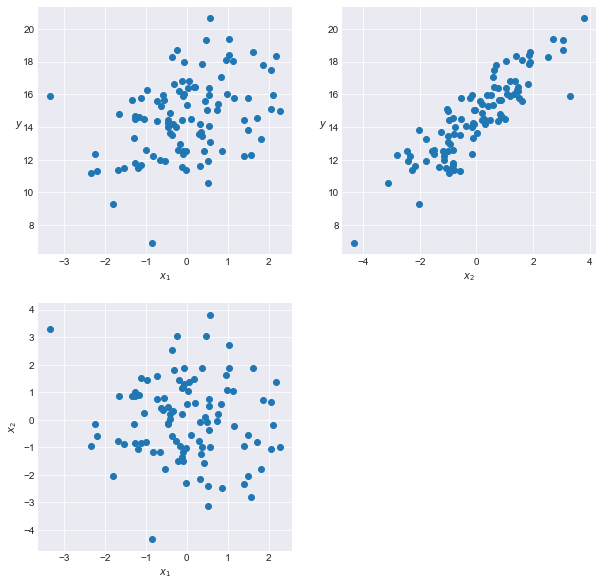

In [40]:
scatter_plot(X_centered, y)

### コード4.35 線形重回帰モデルのパラメータのKDEとトレースを出力する

In [41]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha_tmp + pm.math.dot(beta, X_centered)
    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean))
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_mlr = pm.sample(5000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha_tmp]
 92%|█████████▏| 5058/5500 [00:09<00:00, 508.19it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 5500/5500 [00:09<00:00, 556.83it/s]
The acceptance probability does not match the target. It is 0.9041654751171997, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132ce6198>,
      dtype=object)

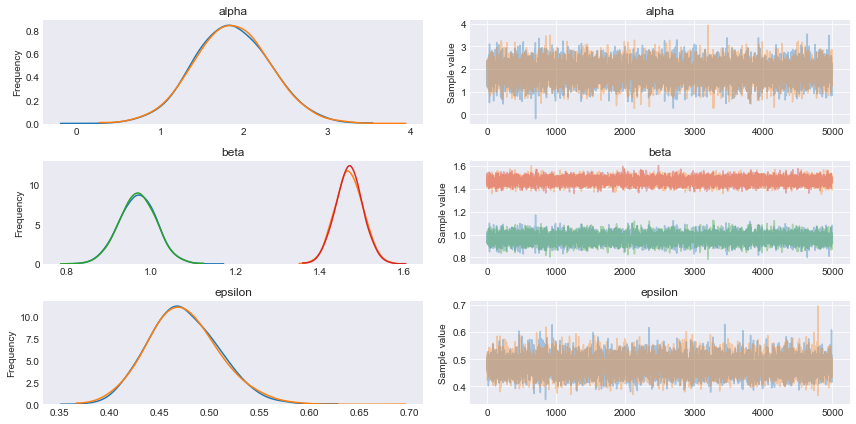

In [43]:
varnames = ['alpha', 'beta', 'epsilon']
pm.traceplot(trace_mlr, varnames)

In [44]:
pm.summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,1.86,0.45,4.07e-03,0.99,2.77,11651.44,1.0
beta__0,0.97,0.04,3.89e-04,0.88,1.05,11965.23,1.0
beta__1,1.47,0.03,2.95e-04,1.40,1.53,10841.38,1.0
epsilon,0.47,0.03,3.30e-04,0.41,0.55,10048.28,1.0


### コード4.37 交絡変数を持つ線形重回帰モデルの変数間の散布図を描く

In [45]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

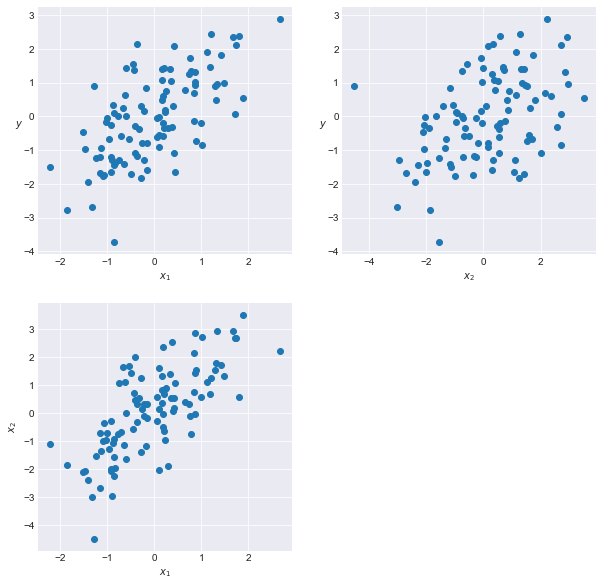

In [46]:
scatter_plot(X, y)

### コード 4.39 交絡変数を持つ線形重回帰モデルのパラメータのKDEとトレースを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha_tmp]
100%|██████████| 5500/5500 [00:08<00:00, 653.22it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12fb7b0f0>,
      dtype=object)

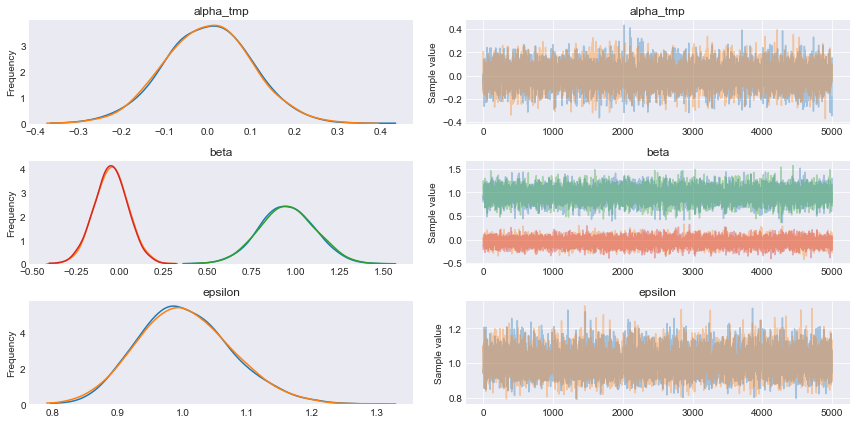

In [48]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha_tmp', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_red = pm.sample(5000, njobs=1)
    
pm.traceplot(trace_red)

In [49]:
pm.summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_tmp,8.16e-04,0.10,9.23e-04,-0.20,0.19,9094.23,1.0
beta__0,9.52e-01,0.16,1.90e-03,0.66,1.27,6956.70,1.0
beta__1,-4.94e-02,0.09,1.16e-03,-0.25,0.13,6952.99,1.0
epsilon,1.01e+00,0.07,7.84e-04,0.87,1.15,8094.57,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha_tmp]
100%|██████████| 5500/5500 [00:05<00:00, 940.15it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_tmp,-5.25e-03,0.10,8.55e-04,-0.19,0.20,13676.70,1.0
beta,8.93e-01,0.11,7.15e-04,0.68,1.10,16710.52,1.0
epsilon,1.00e+00,0.07,6.56e-04,0.86,1.15,13351.65,1.0


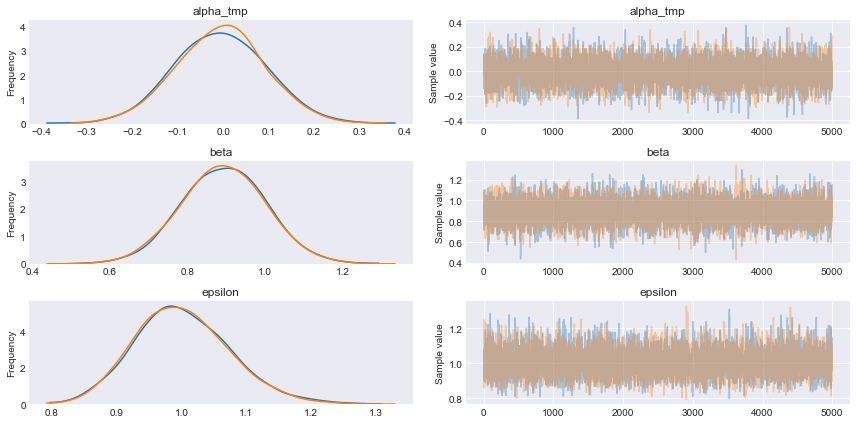

In [50]:
X = x_1
with pm.Model() as model_red:
    alpha = pm.Normal('alpha_tmp', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_red = pm.sample(5000, njobs=1)
    
pm.traceplot(trace_red)
pm.summary(trace_red)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha_tmp]
100%|██████████| 5500/5500 [00:04<00:00, 1139.88it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_tmp,-0.06,0.12,1.04e-03,-0.29,0.18,12503.48,1.0
beta,0.36,0.08,6.37e-04,0.22,0.52,13745.44,1.0
epsilon,1.18,0.09,7.53e-04,1.02,1.36,14147.53,1.0


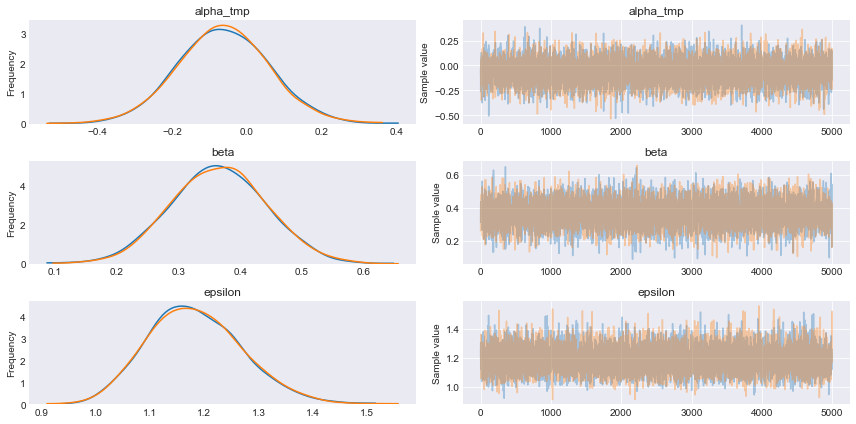

In [51]:
X = x_2
with pm.Model() as model_red:
    alpha = pm.Normal('alpha_tmp', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_red = pm.sample(5000, njobs=1)
    
pm.traceplot(trace_red)
pm.summary(trace_red)

### コード 4.42 線形重回帰モデルにおけるマスキング効果を調べるためにデータ散布図を描く

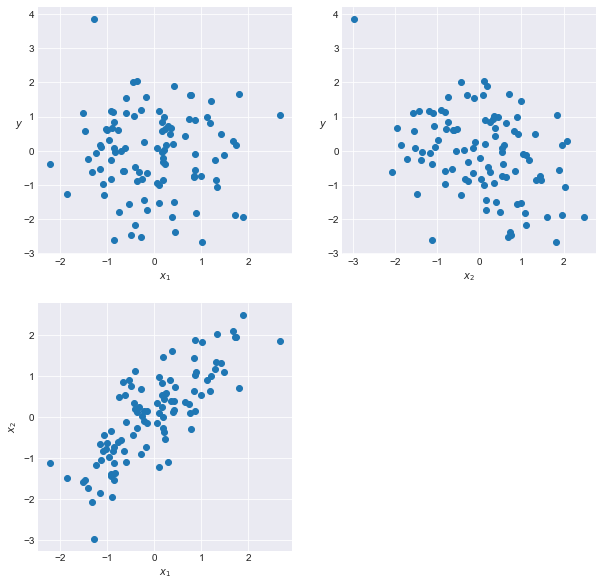

In [52]:
np.random.seed(314)
N = 100
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(loc=x_1 * r, scale=(1 - r**2)**0.5)
y = np.random.normal(loc=x_1 - x_2)
X = np.vstack((x_1, x_2))

scatter_plot(X, y)

### コード 4.43 線形重回帰モデルにおけるマスキング効果を調べるためにKDEとトレースを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha_tmp]
100%|██████████| 5500/5500 [00:08<00:00, 648.34it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_tmp,2.77e-04,0.10,1.00e-03,-0.21,0.19,9569.53,1.0
beta__0,9.70e-01,0.18,2.56e-03,0.61,1.31,6862.31,1.0
beta__1,-1.08e+00,0.16,1.99e-03,-1.39,-0.78,6566.04,1.0
epsilon,1.01e+00,0.07,8.46e-04,0.86,1.15,8439.92,1.0


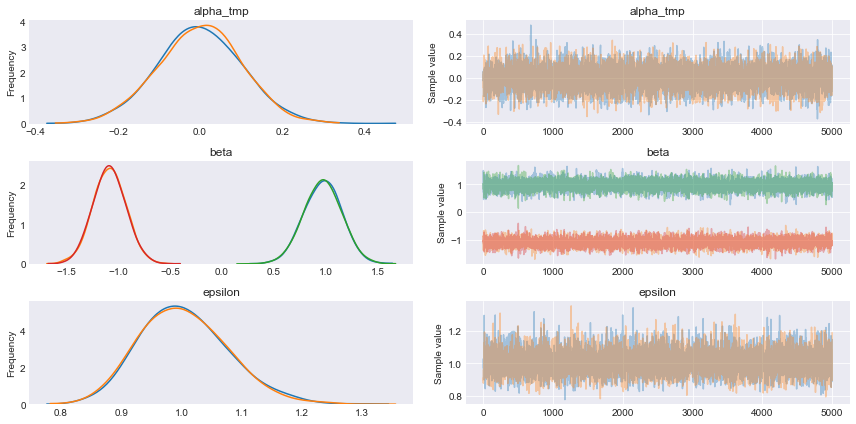

In [53]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_ma = pm.sample(5000, njobs=1)
    
pm.traceplot(trace_ma)
pm.summary(trace_ma)

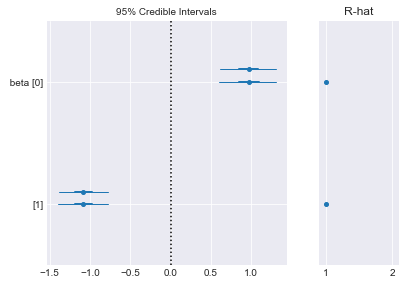

In [54]:
pm.forestplot(trace_ma, varnames=['beta'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha_tmp]
100%|██████████| 5500/5500 [00:06<00:00, 889.96it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_tmp,-0.08,0.12,9.54e-04,-0.32,0.15,14601.93,1.0
beta,-0.02,0.13,1.19e-03,-0.30,0.23,15122.90,1.0
epsilon,1.23,0.09,8.38e-04,1.06,1.40,12304.05,1.0


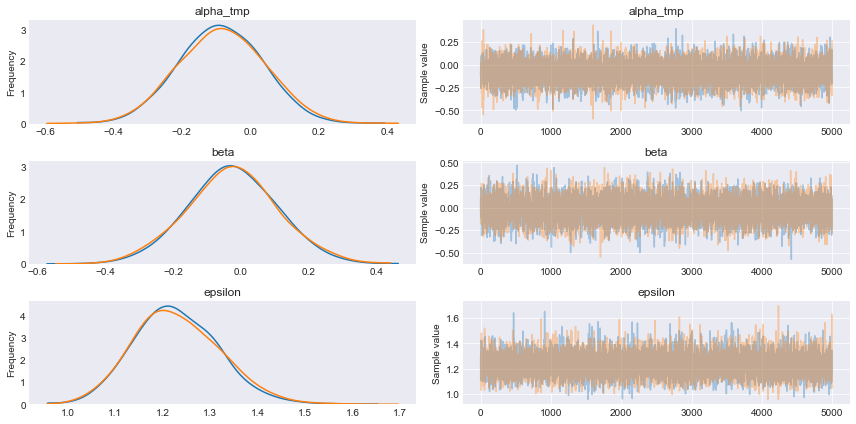

In [55]:
X = x_1
with pm.Model() as model_red:
    alpha = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_ma = pm.sample(5000, njobs=1)
    
pm.traceplot(trace_ma)
pm.summary(trace_ma)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha_tmp]
100%|██████████| 5500/5500 [00:06<00:00, 864.77it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_tmp,-0.06,0.12,9.96e-04,-0.29,0.16,13078.78,1.0
beta,-0.41,0.11,8.13e-04,-0.62,-0.21,14894.12,1.0
epsilon,1.15,0.08,7.43e-04,0.99,1.32,12566.45,1.0


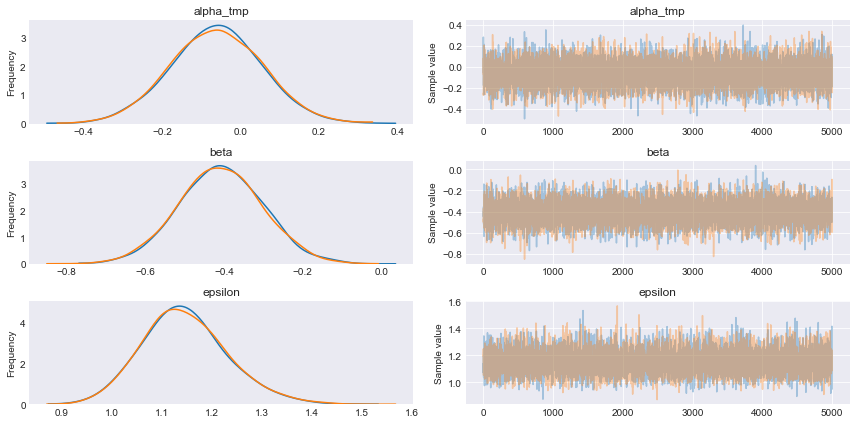

In [56]:
X = x_2
with pm.Model() as model_red:
    alpha = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_ma = pm.sample(5000, njobs=1)
    
pm.traceplot(trace_ma)
pm.summary(trace_ma)